In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn import linear_model

pd.options.display.max_columns = 50

In [18]:
df = pd.read_csv("../Data/immo_data.csv")
desc = pd.read_csv("../Data/immo_data_column_description.csv")

In [19]:
def drop_columns(df):
    """ Remove (supposedly) unimportant columns """
    return df.drop(
        [
            "scoutId",
            "houseNumber",
            "geo_bln",
            "geo_krs",
            "geo_plz",
            "date",
            "street",
            "streetPlain",
            "description",
            "facilities",
            "regio3",
            "firingTypes",
            "telekomHybridUploadSpeed",
            "totalRent",
            "baseRentRange",
        ],
        axis=1,
    )


def remove_outliers(df, lower_limit=0.005, upper_limit=0.995):
    """ Removing the (lower and upper) outliers """
    dfc = df.copy()
    columns_with_outliers = [
        "serviceCharge",
        "yearConstructed",
        "noParkSpaces",
        "baseRent",
        "livingSpace",
        "noRooms",
        "floor",
        "numberOfFloors",
        "heatingCosts",
        "lastRefurbish",
    ]
    
    # For each column we keep: Data that is < (99.5% quantile) and > (0.5% quantile) OR that is NaN (we will deal with this later) 
    upper_limits = df[columns_with_outliers].quantile(upper_limit)
    lower_limits = df[columns_with_outliers].quantile(lower_limit)
    
    for colname in columns_with_outliers:
        col = dfc[colname]
        dfc = dfc[
            ((col <= upper_limits[colname]) & (col >= lower_limits[colname]))
            | col.isna()
        ]
    return dfc


def remove_rows_with_NaN_target(df):
    """ Removing the records without a label """
    return df[df["baseRent"].isna() == False]


def impute_NaNs(df):
    """ Replacing NaNs with mean or most frequent """
    dfc = df.copy()
    categorical_columns = dfc.select_dtypes(exclude=np.number).columns
    imp_freq = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    dfc.loc[:, categorical_columns] = imp_freq.fit_transform(dfc[categorical_columns])

    numeric_columns = dfc.select_dtypes(include=np.number).columns
    imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
    #dfc.loc[:, numeric_columns] = imp_mean.fit_transform(dfc[numeric_columns])
    dfc[numeric_columns] = imp_mean.fit_transform(dfc[numeric_columns])
    return dfc


def print_evaluation(pipeline_or_model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, feature_names):
    """ Output of R2 value, MSE and MAE for training and test set """
    r2_train = r2_score(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

    r2_test = r2_score(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
    
    print(
        f"{pipeline_or_model} Evaluation:\n"
        f"{'':6} {'R²':>10} | {'MSE':>14} | {'MAE':>10} | {'MAPE':>10} | {'rows':>8} | {'columns':>8}\n"
        f"{'Train':6} {r2_train:10.5f} | {mse_train:14.2f} | {mae_train:10.2f} | {mape_train:10.2f} | {X_train.shape[0]:8} | {X_train.shape[1]:8}\n"
        f"{'Test':6} {r2_test:10.5f} | {mse_test:14.2f} | {mae_test:10.2f} | {mape_test:10.2f} | {X_test.shape[0]:8} | {X_test.shape[1]:8}\n"
    )

In [20]:
from sklearn.model_selection import GridSearchCV

# Prepare the data
df_reduced = drop_columns(df.sample(10000, random_state=42))
#df_reduced = drop_columns(df)
df_reduced = remove_outliers(df_reduced)
df_reduced = remove_rows_with_NaN_target(df_reduced)
df_reduced = impute_NaNs(df_reduced)
df_reduced = pd.get_dummies(df_reduced)
y = df_reduced.pop("baseRent")

# Training-Test-Split
X_train, X_test, y_train, y_test = train_test_split(df_reduced, y, test_size=0.2, random_state=0)

# Training and Hyperparameter search
parameters = {"alpha": [1e-3, 1e-1, 1, 10]} #"max_depth"=[1,2,3,4,79]
m = linear_model.Ridge(random_state=42)
gs = GridSearchCV(m, parameters, n_jobs=-1)
gs.fit(X_train, y_train)

# Predict with the best model
y_train_pred = gs.predict(X_train)
y_test_pred = gs.predict(X_test)

# Evaluation. The best model is stored under gs.best_estimator_. 
print_evaluation(gs.best_estimator_, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, feature_names=df_reduced.columns)

Ridge(alpha=1, random_state=42) Evaluation:
               R² |            MSE |        MAE |       MAPE |     rows |  columns
Train     0.84369 |       25629.80 |     104.07 |       0.18 |     7742 |      505
Test      0.82320 |       28617.03 |     113.75 |       0.20 |     1936 |      505


### Task 1
Train a random forest for the apartment example. Experiment with the parameters ``n_estimators``, ``max_depth`` and ``max_features`` to optimize the performance (either manually or with GridSearchCV --> Caution, computing time!). What do the parameters mean?    

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, max_depth=12, max_features="sqrt", n_jobs=-1)
rf.fit(X_train, y_train)

# Prediction with the best model
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Evaluation.
print_evaluation(rf, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, feature_names=df_reduced.columns)

RandomForestRegressor(max_depth=12, max_features='sqrt', n_estimators=500,
                      n_jobs=-1) Evaluation:
               R² |            MSE |        MAE |       MAPE |     rows |  columns
Train     0.81996 |       29522.47 |     121.14 |       0.23 |     7742 |      505
Test      0.73198 |       43383.68 |     139.81 |       0.26 |     1936 |      505


The individual trees of the ensemble are stored in ``.estimators_`` of the ``RandomForestRegressor``. This allows you to visualize them, for example.

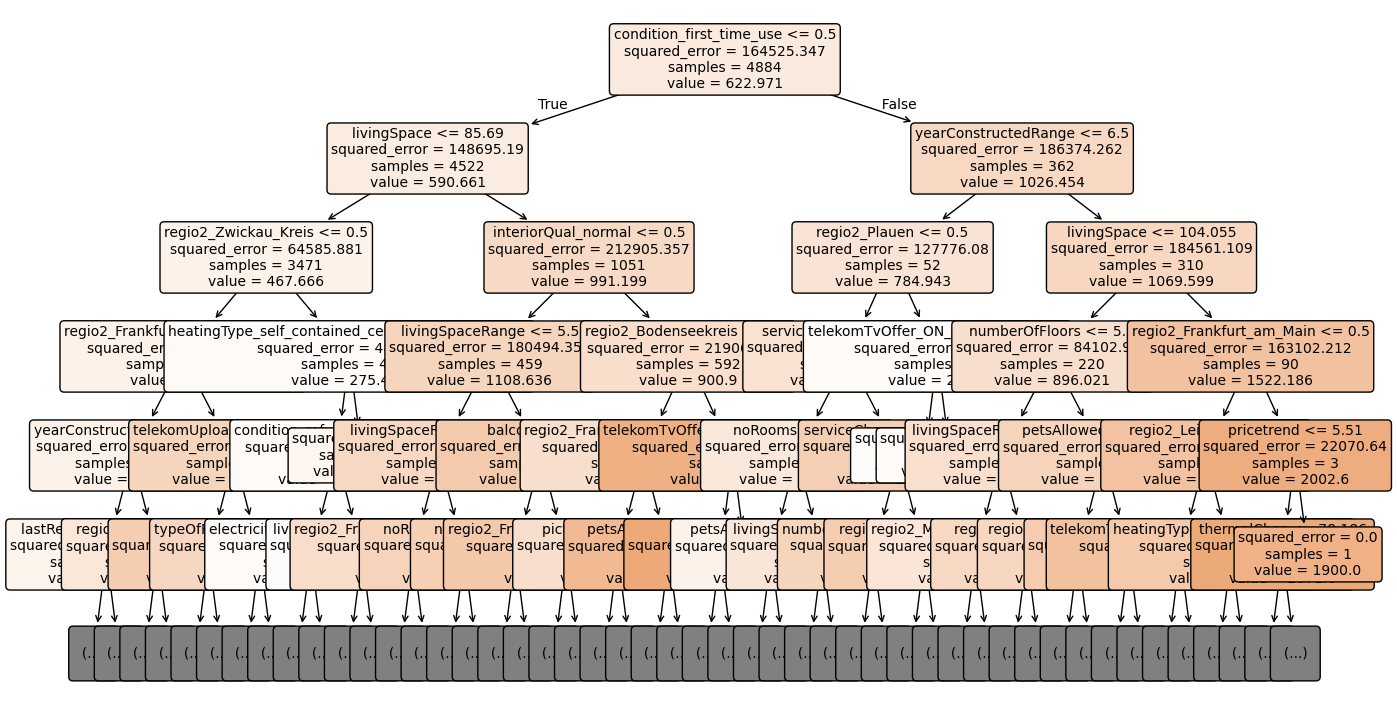

In [24]:
from sklearn.tree import plot_tree
plt.rcParams['figure.figsize'] = [16, 9]
nodes = plot_tree(rf.estimators_[1], feature_names=df_reduced.columns, rounded=True, filled=True, fontsize=10, max_depth=5)

### Task 2
Train a AdaBoost regression model for the apartment example. Experiment with the parameters ``n_estimators``, ``learning_rate`` and ``loss`` to optimize the performance (either manually or with GridSearchCV --> Caution, computing time!). What do the parameters mean?

In [26]:
from sklearn.ensemble import AdaBoostRegressor

ab = AdaBoostRegressor(n_estimators=100, learning_rate=0.01, loss='exponential')
ab.fit(X_train, y_train)

y_train_pred = ab.predict(X_train)
y_test_pred = ab.predict(X_test)

print_evaluation(ab, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, feature_names=df_reduced.columns)

AdaBoostRegressor(learning_rate=0.01, loss='exponential', n_estimators=100) Evaluation:
               R² |            MSE |        MAE |       MAPE |     rows |  columns
Train     0.60538 |       64707.10 |     177.13 |       0.32 |     7742 |      505
Test      0.58022 |       67947.55 |     182.85 |       0.33 |     1936 |      505


### Task 3
Which algorithm is implemented in the following code?

In [27]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from scipy.stats import mode

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_trees = 500
accuracy_scores = []

Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for k in range(n_trees):
    X_train_, y_train_ = resample(X_train, y_train, replace=True)
    
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train_, y_train_)
    
    Y_pred[k] = clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, clf.predict(X_test)))

y_pred, count = mode(Y_pred, keepdims=True)
print(accuracy_score(y_test, y_pred[0]))
print(np.mean(accuracy_scores))

1.0
0.9874666666666667


Answer: Bagging (for decision tree).

In [28]:
from sklearn.ensemble import AdaBoostRegressor

ab = AdaBoostRegressor(n_estimators=100, learning_rate=1, loss='linear')
ab.fit(X_train, y_train)

y_train_pred = ab.predict(X_train)
y_test_pred = ab.predict(X_test)

print_evaluation(ab, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, feature_names=df_reduced.columns)

AdaBoostRegressor(learning_rate=1, n_estimators=100) Evaluation:
               R² |            MSE |        MAE |       MAPE |     rows |  columns
Train     0.98781 |           0.01 |       0.05 |       0.04 |      120 |        4
Test      0.97276 |           0.02 |       0.08 |       0.06 |       30 |        4
